# Spurious St. Gallen - Odd Correlations
Rafael James Novotny, Linus Flury, Dominik Castelberg

In [2]:
import math
import os
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt

## Helpers

In [3]:
# Config
## Paths
conf_root = '../'
conf_merged_folder_path = conf_root + 'useful_data/2_processed_data/'
conf_cache_folder_path = conf_root + 'cache/'
conf_correlation_matrix_path = conf_cache_folder_path + 'corr_matrix.dat'

## Variables
conf_file_size_threshold = 30000
conf_correlation_selection_threshold = 0.6

In [6]:
def getcrossminlevel(dataframes1, dataframes2):
    # Levels: y: 3, m:2, d: 1, h:0, error: -1
    return max(getminlevel(dataframes1), getminlevel(dataframes2))


def getminlevel(dataframes):
    for k in range(4):
        if not pd.isnull(dataframes[k].iloc[0, 0]):
            return k

    return -1


def cropdates(dataframes1, dataframes2):
    min1 = dataframes1.iloc[0, 0]
    min2 = dataframes2.iloc[0, 0]
    max1 = dataframes1.iloc[-1, 0]
    max2 = dataframes2.iloc[-1, 0]

    df_1 = dataframes1.copy()
    df_2 = dataframes2.copy()
    if min1 < min2:
        df_1 = df_1[df_1.iloc[:, 0] >= min2]
    else:
        df_2 = df_2[df_2.iloc[:, 0] >= min1]

    if max1 > max2:
        df_1 = df_1[df_1.iloc[:, 0] <= max2]
    else:
        df_2 = df_2[df_2.iloc[:, 0] <= max1]

    return df_1, df_2


def combinedf(df_1, df_2):
    # check if works
    df_1.set_index(df_1.iloc[:, 0], inplace=True)
    df_2.set_index(df_2.iloc[:, 0], inplace=True)
    df_1 = df_1.drop(df_1.columns[[0]], axis=1)
    df_2 = df_2.drop(df_2.columns[[0]], axis=1)
    df = pd.merge(df_1,df_2, how='inner', left_index=True, right_index=True)
    return df.dropna()

def create_dataframe_collection(filename: str):
    df_y = pd.read_csv(filename, sep=';', usecols=[6, 7], low_memory=False)
    df_y.iloc[:, 0] = pd.to_datetime(df_y.iloc[:, 0], format='%Y')
    df_y = df_y.sort_values(df_y.columns[0], ascending=True)
    df_m = pd.read_csv(filename, sep=';', usecols=[4, 5], low_memory=False)
    df_m.iloc[:, 0] = pd.to_datetime(df_m.iloc[:, 0], format='%Y-%m')
    df_m = df_m.sort_values(df_m.columns[0], ascending=True)
    df_d = pd.read_csv(filename, sep=';', usecols=[2, 3], low_memory=False)
    df_d.iloc[:, 0] = pd.to_datetime(df_d.iloc[:, 0], format='%Y-%m-%d')
    df_d = df_d.sort_values(df_d.columns[0], ascending=True)
    df_h = pd.read_csv(filename, sep=';', usecols=[0, 1], low_memory=False)
    df_h.iloc[:, 0] = pd.to_datetime(df_h.iloc[:, 0][0], format='%Y-%m-%dT%H')
    df_h = df_h.sort_values(df_h.columns[0], ascending=True)
    return [df_h, df_d, df_m, df_y, filename]

dataframes_list = []
counter = 0
for file in os.listdir(conf_merged_folder_path):
    filename = os.fsdecode(file)
    if filename.endswith(".csv") or int(filename.split('_')[0]) > conf_file_size_threshold:
        dataframes_list.append(create_dataframe_collection(conf_merged_folder_path + filename))
        counter += 1


corrMatrix = np.zeros((counter, counter))
for i in range(counter):
    current_file_origin = os.path.basename(dataframes_list[i][4])
    current_file_length = int(current_file_origin.split('_')[0])
    if int(current_file_length) > conf_file_size_threshold: break
    for j in range(i+1, counter):
        this_file_origin = os.path.basename(dataframes_list[j][4])
        this_file_length = int(this_file_origin.split('_')[0])
        if this_file_length > conf_file_size_threshold or this_file_length == current_file_length: continue


        level = getcrossminlevel(dataframes_list[i], dataframes_list[j])
        if level == -1:
            continue
        # Levels: y: 3, m:2, d: 1, h:0, error: -1
        dframe1, dframe2 = cropdates(dataframes_list[i][level], dataframes_list[j][level])
        df_for_corr = combinedf(dframe1, dframe2)
        if (df_for_corr[df_for_corr.columns[0]].count() > 3):
            corrMatrix[i, j] = df_for_corr.iloc[:, 0].corr(df_for_corr.iloc[:, 1])
        else:
            corrMatrix[i, j] = 0


np.savetxt(conf_correlation_matrix_path, corrMatrix, delimiter=';')

TypeError: Image data of dtype object cannot be converted to float

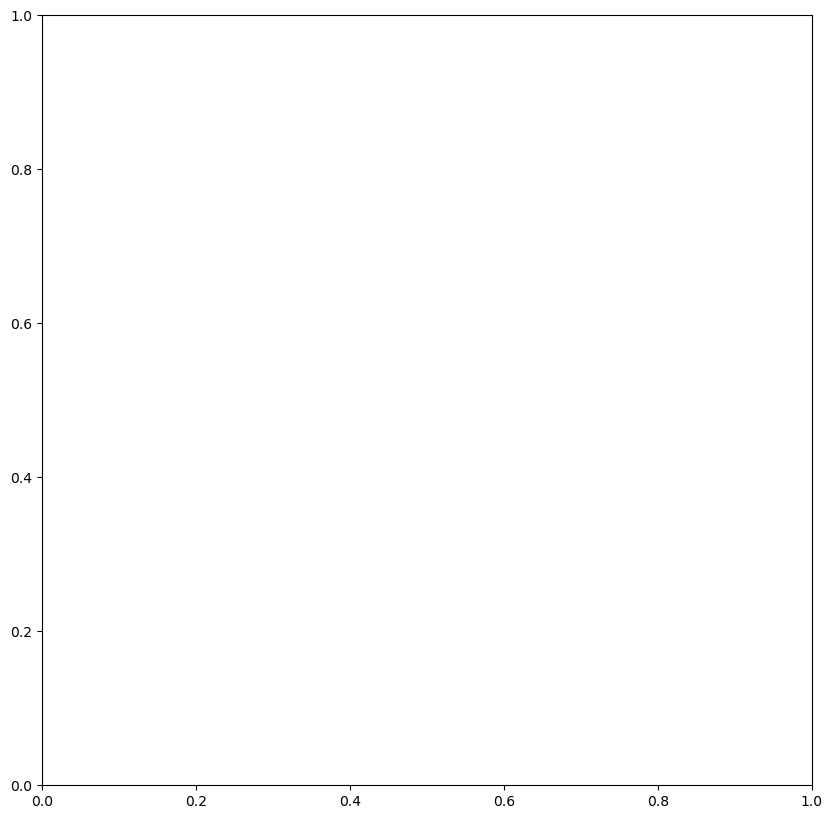

In [7]:
# PLOT HELPERS
def plot_stats(df: pd.DataFrame, title: str, x_label: str, y1_label: str, y2_label: str):
    ax1 = df.plot('x', 'y1', color='b')
    ax1.set_ylabel(y1_label)
    ax1.set_xlabel(x_label)
    ax_twin = ax1.twinx()
    ax2 = df.plot('x', 'y2', ax=ax_twin, secondary_y=True, color='r')
    ax2.set_ylabel(y2_label)
    plt.title(title)
    plt.show()

def plot_matrix(matrix: np.ndarray, labels: list[str]):
  labels.insert(0, "")
  fig = plt.figure(figsize=(10, 10))
  sub_plot = fig.add_subplot(1, 1, 1)
  sub_plot_content = sub_plot.matshow(matrix, interpolation="nearest")
  fig.colorbar(sub_plot_content)
  if len(labels) < 10:
    sub_plot.set_xticklabels(labels)
    sub_plot.set_yticklabels(labels)
  plt.show()

#Sample
#test_df = pd.DataFrame({'x' : ['1991-01-01T02','1991-01-02T02','1991-01-04T02','1991-01-05T02'],'y1' : [10,20,30,40],'y2' : [100,50,-30,-50]})
#plot_stats(test_df, 'This is a Title', 'X axis', 'Y1 axis', 'Y2 axis')    

# load stored correlation matrix
correlation_matrix: np.ndarray = np.loadtxt(conf_correlation_matrix_path, np.ndarray, delimiter=';')
correlation_matrix_labels = []

# list .csv files in merged folder
files = [f for f in os.listdir(conf_merged_folder_path) if f.endswith('.csv')]

for i in range(counter):
    for j in range(i + 1, counter):
        if abs(float(correlation_matrix[i, j])) > conf_correlation_selection_threshold:
            path_data1 = files[i]
            dataframe_collection_data1 = create_dataframe_collection(conf_merged_folder_path + path_data1)
            path_data2 = files[j]
            dataframe_collection_data2 = create_dataframe_collection(conf_merged_folder_path + path_data2)
            level = getcrossminlevel(dataframes_list[i], dataframes_list[j])
            if level == -1:
                continue
            dframe1, dframe2 = cropdates(dataframe_collection_data1[level], dataframe_collection_data2[level])
            df = combinedf(dframe1, dframe2)
            df.insert(0, 'x', df.index)
            y1_label = path_data1.split('__')[1][:-4].replace('_', ' ')
            y2_label = path_data2.split('__')[1][:-4].replace('_', ' ')
            df = df.rename(columns={df.columns[1]: 'y1', df.columns[2]: 'y2'})
            plot_stats(
                df=df,
                title=y1_label + ' X ' + y2_label + ' (' + str(correlation_matrix[i, j]) + ')', x_label='Date',
                y1_label=y1_label,
                y2_label=y2_label
            )
